# Preamble

## setup of environment

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/Few-Shot Project/registration-vxm/source-code

/content/gdrive/My Drive/Few-Shot Project/registration-vxm/source-code


## pystrum

In [3]:
# !git clone https://github.com/adalca/pystrum

In [4]:
!pip install ./pystrum

Processing ./pystrum
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for pystrum: filename=pystrum-0.2-py3-none-any.whl size=19535 sha256=3d557ae414c70c16a516411a6526508f48a159f5030d264b85348eec0b56da53
  Stored in directory: /tmp/pip-ephem-wheel-cache-3s5a0uwi/wheels/8b/c2/51/e4f0cffd5826e3a191dc47efa9c4c7305c4a23d5c837cca8e2
Successfully built pystrum


## neurite

In [5]:
# !git clone https://github.com/adalca/neurite

In [6]:
!pip install ./neurite

Processing ./neurite
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for neurite: filename=neurite-0.1-py3-none-any.whl size=105915 sha256=a34e43398f151411cd290876395b8f118b2d8f29f33407c1d9725dc9956229dd
  Stored in directory: /tmp/pip-ephem-wheel-cache-f2jn5rlj/wheels/3e/b6/41/8e415c9f00ec3fa1dccc3cbbfe82a346778b13612c25f2c401
Successfully built neurite


## voxelmorph

In [7]:
# !git clone https://github.com/voxelmorph/voxelmorph

In [8]:
!pip install ./voxelmorph

Processing ./voxelmorph
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for voxelmorph: filename=voxelmorph-0.1-py3-none-any.whl size=53385 sha256=fcad9f687a60674681be759e792fea6f9527d4dda1a0b6cff6982b8e3678ce79
  Stored in directory: /tmp/pip-ephem-wheel-cache-o8hlhbk4/wheels/0a/19/7c/2de4bd28875534236306f60e209a8f98ba615fea930c4cb7b7
Successfully built voxelmorph


## imports

In [9]:
!pip install tqdm -q
!pip install pypng -q

     |████████████████████████████████| 649 kB 4.1 MB/s 


In [10]:
# imports
import os, sys
import glob
from tqdm import tqdm
import time
import png
import numpy as np
import shutil
import imageio
import pickle
import random
import torch

In [11]:
# local imports
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import neurite as ne

---

# Data

In [12]:
%cd ../

/content/gdrive/My Drive/Few-Shot Project/registration-vxm


## load & normalize

In [13]:
# load
with open('./structured-data/filtered_images.pkl', 'rb') as f:
    patients = pickle.load(f)

In [14]:
for p_id in patients.keys():
    print(str(p_id) + ":", patients.get(p_id).shape) 

1: (24, 256, 256)
2: (27, 256, 256)
3: (25, 256, 256)
5: (28, 256, 256)
8: (30, 256, 256)
10: (25, 256, 256)
13: (33, 256, 256)
15: (30, 256, 256)
19: (29, 256, 256)
20: (28, 256, 256)
21: (22, 256, 256)
22: (30, 256, 256)
31: (23, 256, 256)
32: (35, 256, 256)
33: (31, 256, 256)
34: (29, 256, 256)
36: (27, 256, 256)
37: (28, 256, 256)
38: (28, 256, 256)
39: (26, 256, 256)


In [15]:
# normalize data
for p_id in patients.keys():
    max_ = patients.get(p_id).max()
    patients[p_id] = patients.get(p_id).astype('float64')/max_

In [16]:
# verify
for p_id in patients.keys():
    print(str(p_id) + ":", patients.get(p_id).min(), "-", patients.get(p_id).max()) 

1: 0.0 - 1.0
2: 0.0 - 1.0
3: 0.0 - 1.0
5: 0.0 - 1.0
8: 0.0 - 1.0
10: 0.0 - 1.0
13: 0.0 - 1.0
15: 0.0 - 1.0
19: 0.0 - 1.0
20: 0.0 - 1.0
21: 0.0 - 1.0
22: 0.0 - 1.0
31: 0.0 - 1.0
32: 0.0 - 1.0
33: 0.0 - 1.0
34: 0.0 - 1.0
36: 0.0 - 1.0
37: 0.0 - 1.0
38: 0.0 - 1.0
39: 0.0 - 1.0


## visualize

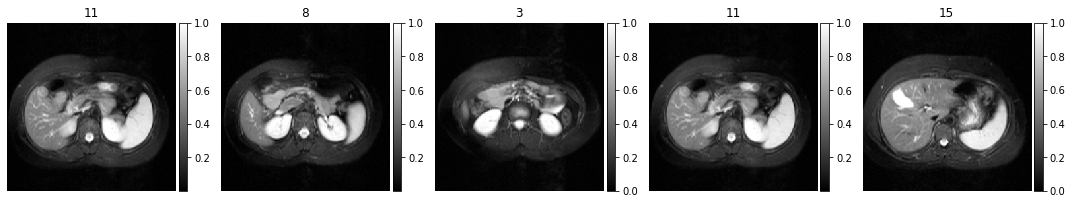

In [17]:
p_id = np.random.choice(list(patients.keys()), 1)[0]
idx = np.random.randint(0, patients.get(p_id).shape[0], size=5)

# visualize
examples = [e for e in patients.get(p_id)[idx, ...]]
ne.plot.slices(examples, cmaps=['gray'], do_colorbars=True, titles=idx, imshow_args=[{'origin':'lower'}]);

---

## data_generator

In [77]:
import torch
from torch.utils.data import Dataset
import numpy as np


class BasicDataset(Dataset):
    def __init__(self, patients, distance, swap):
        data = []
        for p_id, patient in patients.items():
            for i in range(patient.shape[0]):
                data.append((p_id, patient[i, :, :]))
        self.data = data.copy()
        self.distance = distance
        self.swap = swap
        self.vol_shape = data[0][1].shape
        self.ndims = len(self.vol_shape)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        if index + self.distance >= len(self.data):
            return self.__getitem__((index + self.distance) % len(self.data))  
        id1, slice1 = self.data[index]
        id2, slice2 = self.data[index + self.distance]

        if id1 != id2:
            return self.__getitem__(index + self.distance)

        slice1 = torch.tensor(slice1).unsqueeze(-1)
        slice2 = torch.tensor(slice2).unsqueeze(-1)
        outputs = [slice1, slice2]
        if self.swap and np.random.randint(0, 2) == 1:
            outputs = [slice2, slice1]

        return tuple(outputs)


In [78]:
from torch.utils.data import DataLoader


def get_dataloader(batch_size, shuffle=False, pin_memory=False, workers=0):
    dataset = BasicDataset(patients, distance=1, swap=False)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory,num_workers=workers)
    zero_phi = torch.zeros(batch_size, *dataset.vol_shape, dataset.ndims)

    return dataloader, zero_phi


In [79]:
def data_generator(patients, bs, patient_id=None, slice_ids=[]):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """
    
    if len(slice_ids) != 0:
        bs = len(slice_ids)
    
    # extract data shape and dimension
    vol_shape = list(patients.values())[0].shape[1:] 
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([bs, *vol_shape, ndims])
    
    while True:
        if patient_id is None:
            patient_id = np.random.choice(list(patients.keys()), 1)[0]
        patient = np.array(patients.get(patient_id))

        if len(slice_ids) == 0:
            slice_ids = np.random.randint(0, patient.shape[0] - 1, size=bs)
        slice_ids = np.array(slice_ids)

        moving_images = patient[slice_ids, ..., np.newaxis]
        fixed_images = patient[slice_ids + 1, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image)
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

# Args

In [90]:
class Args():
    def __init__(self):        
        self.lr = 0.001
        self.epochs = 100
        self.batch_size = 4
        self.lam = 0.01 
        self.loss = 'mse' 
        self.load_model = None
        self.steps_per_epoch = int(2 * 20 * 30 / self.batch_size)
        self.initial_epoch = 0 
        self.int_steps = 7 
        self.int_downsize = 2 
        self.model_dir = './trained-models/torch/1/'

In [91]:
 args = Args()

# Model

In [92]:
train_generator = data_generator(patients, bs=args.batch_size)
inshape = next(train_generator)[0][0].shape[1:-1]

In [93]:
device = 'cuda'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
torch.backends.cudnn.deterministic = True

In [94]:
enc_nf = [16, 32, 32, 32]
dec_nf = [32, 32, 32, 32, 32, 16, 16]

if args.load_model:
    model = vxm.networks.VxmDense.load(args.load_model, device)
else:
    model = vxm.networks.VxmDense(
        inshape=inshape,
        nb_unet_features=[enc_nf, dec_nf],
        int_steps=args.int_steps,
        int_downsize=args.int_downsize
    )

model.to(device)
_ = model.train()

In [95]:
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

In [96]:
if args.loss == 'ncc':
    image_loss_func = vxm.losses.NCC().loss
elif args.loss == 'mse':
    image_loss_func = vxm.losses.MSE().loss
else:
    raise ValueError('Image loss should be "mse" or "ncc", but found "%s"' % args.image_loss)

losses = [image_loss_func]
weights = [1]
losses += [vxm.losses.Grad('l2', loss_mult=args.int_downsize).loss]
weights += [args.lam]

# Train

In [97]:
os.makedirs(args.model_dir, exist_ok=True)

In [98]:
dataloader, zero_phi = get_dataloader(args.batch_size)

In [ ]:
for epoch in range(args.initial_epoch, args.epochs):

    # save model checkpoint
    if epoch % 20 == 0:
        model.save(os.path.join(args.model_dir, '%04d.pt' % epoch))

    epoch_loss = 0
    epoch_sim_loss = 0
    epoch_smooth_loss = 0
    total_data = 0
    epoch_start_time = time.time()
    
    for inputs in dataloader:
    
        fixed_images = inputs[1]
        bs = fixed_images.shape[0]
        y_true = [fixed_images, zero_phi]
        inputs = [d.to(device).float().permute(0, 3, 1, 2) for d in inputs]
        y_true = [d.to(device).float().permute(0, 3, 1, 2) for d in y_true]

        # run inputs through the model to produce a warped image and flow field
        y_pred = model(*inputs)

        # calculate total loss
        loss = 0
        loss_list = []
        for n, loss_function in enumerate(losses):
            curr_loss = loss_function(y_true[n], y_pred[n]) * weights[n]
            loss_list.append(curr_loss.item())
            loss += curr_loss

        # backpropagate and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss * bs
        epoch_sim_loss += loss_function(y_true[0], y_pred[0]) * bs
        epoch_smooth_loss += loss_function(y_true[1], y_pred[1]) * bs
        total_data += bs      

    # print epoch info
    msg = 'epoch %d/%d, ' % (epoch + 1, args.epochs)
    msg += 'loss= %.4e, ' % (epoch_loss / total_data)
    msg += 'sim_loss= %.4e, ' % (epoch_sim_loss / total_data)
    msg += 'smooth_loss= %.4e, ' % (epoch_smooth_loss / total_data)
    msg += 'time= %.4f, ' % (time.time() - epoch_start_time)
    print(msg, flush=True)

# final model save
model.save(os.path.join(args.model_dir, '%04d.pt' % args.epochs))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


epoch 1/100, loss= 5.2588e-03, sim_loss= 1.5560e-03, smooth_loss= 2.8533e-03, time= 16.5644, 
epoch 2/100, loss= 4.0062e-03, sim_loss= 1.5916e-03, smooth_loss= 1.9384e-02, time= 16.3692, 
epoch 3/100, loss= 3.4804e-03, sim_loss= 1.5783e-03, smooth_loss= 3.1099e-02, time= 16.4020, 
epoch 4/100, loss= 3.1325e-03, sim_loss= 1.6064e-03, smooth_loss= 3.4830e-02, time= 16.3449, 
epoch 5/100, loss= 2.7970e-03, sim_loss= 1.5923e-03, smooth_loss= 3.7539e-02, time= 16.3512, 
epoch 6/100, loss= 2.6416e-03, sim_loss= 1.5802e-03, smooth_loss= 3.8739e-02, time= 16.3324, 
epoch 7/100, loss= 2.5966e-03, sim_loss= 1.5800e-03, smooth_loss= 3.9514e-02, time= 16.3559, 
epoch 8/100, loss= 2.4943e-03, sim_loss= 1.5752e-03, smooth_loss= 4.1055e-02, time= 16.3399, 


# Predict

In [ ]:
def show(load_model_path, patients, patient_id=None, slice_ids=[]):

    model = vxm.networks.VxmDense.load(load_model, 'cuda')
    model.to(device)
    model.eval()

    if patient_id is None:
        patient_id = np.random.choice(list(patients.keys()), 1)[0]
    patient = np.array(patients.get(patient_id))
    if len(slice_ids) == 0:
        slice_ids = np.random.randint(0, patient.shape[0] - 1, size=1)

    for i in slice_ids:
        # get some data
        val_generator = data_generator(patients, bs=1, patient_id=patient_id, slice_ids=[i])
        inputs, _ = next(val_generator)
        input_moving, input_fixed = [torch.from_numpy(d).to(device).float().permute(0, 3, 1, 2) for d in inputs]
        moved, warp = model(input_moving, input_fixed, registration=True)

        input_moving = input_moving.detach().cpu().numpy().squeeze(0)
        input_fixed = input_fixed.detach().cpu().numpy().squeeze(0)
        moved = moved.detach().cpu().numpy().squeeze(0)
        warp = warp.detach().cpu().numpy().squeeze(0)

        # visualize
        images = [img[0, :, :] for img in [input_moving, input_fixed, moved, warp]] 
        titles = ['moving', 'fixed', 'moved', 'flow']
        ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True, imshow_args=[{'origin':'lower'}]);

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "


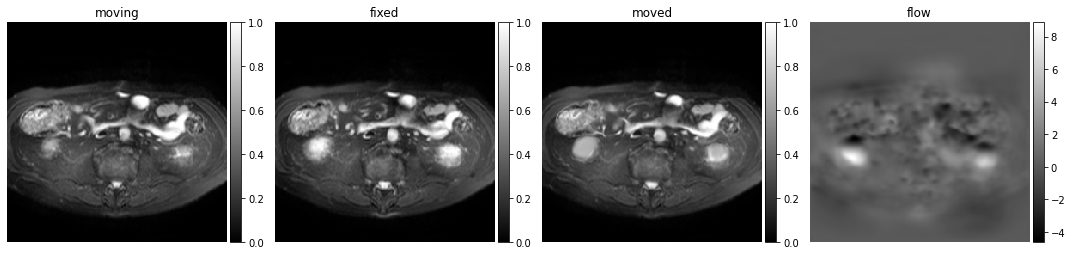

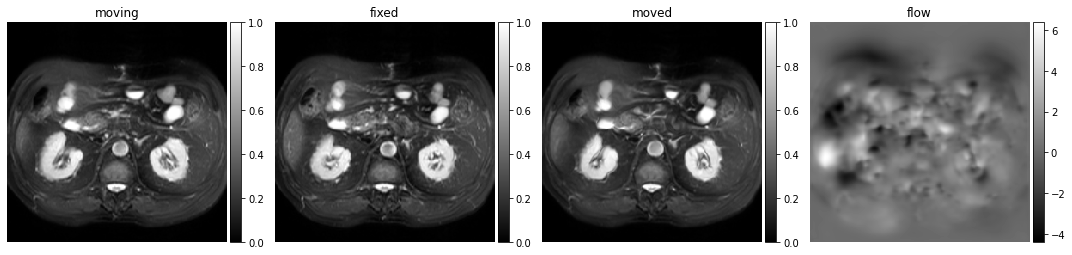

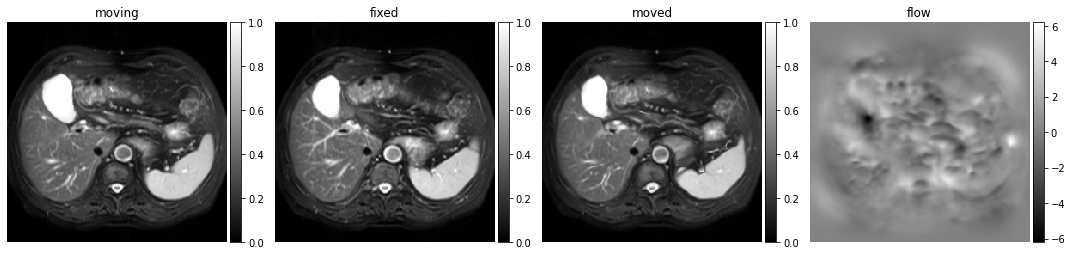

----------------------------------------------------------------------


In [ ]:
slice_ids = [5, 15, 25]
load_model = './trained-models/torch/1/0010.pt'
show(load_model, patients, slice_ids=slice_ids)
print("----------------------------------------------------------------------")